<a href="https://colab.research.google.com/github/kdemertzis/ML_BigData_CyberSecurity/blob/main/Spam_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Email spam filtering

---

## Overview

In this lab, you will design an e-mail spam filter using a Naive Bayes and SVM based classification on the ling-spam dataset. You will explore the impact of feature selection and compare the performance of different variants of an NB classifier and also implement your own SVM based classifier. (Note: You may use the scikitt learn classifiers to only compare the accuracy
of their model to yours).

## Dataset

The ling-spam corpus contains e-mails from the Linguist mailing list categorized as either legitimate or spam emails. The corpus is divided into four sub-folders that contain the same emails that are pre-processed with/without lemmatization and with/without stop-word removal. The e-mails in each sub-folder partitioned into 10 "folds."

In this lab, we will use the first 9 folds from the ling-spam corpus as training data, and the $10^{th}$ fold as test data.

## What you have to do

You will implement your e-mail spam filters in Python. You are free to use any Python libraries that are relevant to the problem.

* Download the ling-spam dataset from http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz

Please use the "lingspam_public01' corpus with both lemmatization and stop-word enabled (under the lemm_stop folder).

* Your first goal is to perform feature selection using the information gain (IG) metric. From the training data, select the top-N features for N = {10, 100, 1000}. Note that feature selection based on the IG metric only accounts for the occurrence of (and not frequency with which terms appear) in the dataset.

* Next, implement the following classifiers:
  * Bernoulli NB classifier with binary features;
  * Multinomial NB with binary features, and
  * Multinomial NB with term frequency (TF) features.

* For each of the three classifiers above and for N = {10, 100, 1000} report the spam precision and spam recall. Spam precision is defined as the fraction of true spam e-mails among all e-mails predicted as spam, and spam recall is defined as fraction of true spam e-mails predicted as spam. Also report the latency of each model.
* Design a Support Vector Machine (SVM) based spam filter. This problem is open ended: for instance, you can choose to use either BF or TF and any feature selection method. Note that you should NOT use the test dataset in picking the hyper-parameters of your spam filter, instead use cross-validation on the training dataset.

Finally, we covered "Adversarial Classification" (https://dl.acm.org/citation.cfm?id=1014066), an approach to update NB based e-mail spam filters in response to attacks that try to evade a basic NB filter. You are expected to implement the techniques presented in this paper. More specifically, you can make the following assumptions:
* The baseline NB classifier uses the **top-10** terms identified using the IG metric and using Boolean features.
* The adversary uses the **ADD-WORDS** strategy. Adding a term to an email incurs unit cost. The attacker seeks to find the minimum cost solution such that each spam email in the test set gets classified as legitimate by the baseline NB classifier.
* Update the baseline NB classifier in response to the attacker's strategy above. You can assume that the defender
pays a unit price for both false positives and false negatives.

## What to submit

* Your Python code in the form of a Google Colab notebook. Please also include a PDF of your colab notebook.
* Your Colab notebook should print:
* a list of the top-10 words identified from Part (1) above, and
* a list of spam precision and spam recall values for each of the three classifiers for N = {10, 100, 1000}. That is, your list should have 9 rows, one for each classifier and N combination.
* For the SVM based spam filter, please describe your methodology, i.e., what kind of features you used, how many features you used and how you selected them, the parameters of the SVM and finally the precision and recall on
the test dataset.
* For Your Neural network model, please report on the model design, input parameters, number of layers, number
of neurons in each layer and finally the accuracy and latency of the model.
* For the adversarial attack, report the False Negative rate of the baseline NB classifier before and after the attacker's modifications to test emails. Also, report the average "cost of the attacker's modifications, averaged
over all spam emails in the test set. Finally, report the False Negative and False Positive rate of the updated NBclassifier.

## Part 0: Importing all the packages

In [1]:
import numpy as np
import pandas as pd
import tarfile
import os
import string
import re
import operator
import seaborn as sns
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline

### Loading the dataset and processing the data

Here, we will use files that under lemm_stop folder

In [2]:
!wget "http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz" -O lingspam_public.tar.gz

--2021-11-19 11:27:21--  http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www.aueb.gr (www.aueb.gr)... 195.251.255.156
Connecting to www.aueb.gr (www.aueb.gr)|195.251.255.156|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2021-11-19 11:27:21--  http://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www2.aueb.gr (www2.aueb.gr)... 195.251.255.138
Connecting to www2.aueb.gr (www2.aueb.gr)|195.251.255.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11564714 (11M) [application/x-gzip]
Saving to: ‘lingspam_public.tar.gz’

lingspam_public.tar 100%[===================>]  11.03M  2.80MB/s    in 3.9s    

2021-11-19 11:27:26 (2.80 MB/s) - ‘lingspam_public.tar.gz’ saved [11564714/11564714]



In [3]:
!tar -xvzf "lingspam_public.tar.gz"

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
lingspam_public/lemm_stop/part2/6-1037msg3.txt
lingspam_public/lemm_stop/part2/6-1039msg1.txt
lingspam_public/lemm_stop/part2/6-1040msg1.txt
lingspam_public/lemm_stop/part2/6-1041msg1.txt
lingspam_public/lemm_stop/part2/6-1044msg1.txt
lingspam_public/lemm_stop/part2/6-1045msg1.txt
lingspam_public/lemm_stop/part2/6-1047msg1.txt
lingspam_public/lemm_stop/part2/6-1048msg1.txt
lingspam_public/lemm_stop/part2/6-1049msg1.txt
lingspam_public/lemm_stop/part2/6-1050msg1.txt
lingspam_public/lemm_stop/part2/6-1050msg2.txt
lingspam_public/lemm_stop/part2/6-1050msg3.txt
lingspam_public/lemm_stop/part2/6-1051msg1.txt
lingspam_public/lemm_stop/part2/6-1052msg1.txt
lingspam_public/lemm_stop/part2/6-1055msg1.txt
lingspam_public/lemm_stop/part2/6-1056msg1.txt
lingspam_public/lemm_stop/part2/spmsga142.txt
lingspam_public/lemm_stop/part2/spmsga143.txt
lingspam_public/lemm_stop/part2/spmsga144.txt
lingspam_public/lemm_stop/part2/spmsga145.txt
lingspam_

#### Defining Lemmatization
Lemmatization is the process of grouping the inflected forms of a word together so they can be analysed as a single item, identified by the word's lemma, or dictionary form. In many languages, words appear in several inflected forms.

We will use the lemm_stop dataset. There are 10 folders totally. We need to count how many spam emails and how many ham email. We will use it later to calculate the probability

In [4]:
lemm_stop = ['lingspam_public/lemm_stop/part1/', 'lingspam_public/lemm_stop/part2/', 'lingspam_public/lemm_stop/part3/',
             'lingspam_public/lemm_stop/part4/', 'lingspam_public/lemm_stop/part5/', 'lingspam_public/lemm_stop/part6/',
             'lingspam_public/lemm_stop/part7/', 'lingspam_public/lemm_stop/part8/', 'lingspam_public/lemm_stop/part9/',
             'lingspam_public/lemm_stop/part10/']

The function `processData()` will process all the text data. The function will return a nested dict finally. It will remove all the punctuations. Finally, the data in text will become a list.

In [5]:
def processData(dir_list):
  all_data = {}
  for dir in dir_list:
     all_data[dir]={}
     file_list = os.listdir(dir) 
     for file_name in file_list: 
        f = open(dir+file_name, "r")
        data = f.read()
        data = data.lower()               # lowercase
        data = data.replace('\n','')
        data = data.replace('\t','')
        data = data.replace("subject",'') # removing subject, it exists all emails, that is why we remove it.
        data = re.sub(r"\d+", "", data)   # removing numbers
        punctuation_string = string.punctuation
        for i in punctuation_string:
          data = data.replace(i,'')
        data = data.split(' ')
        data = ' '.join(data).split()
        
        all_data[dir][file_name] = data
        f.close()
  return all_data

In [6]:
all_data = processData(lemm_stop)

#### Getting the Feature List

In [7]:
def getFeatureList(dir_list, all_data):
  feature_list = []
  for dir in dir_list:
    file_list = os.listdir(dir)
    for file_name in file_list:
      for item in all_data[dir][file_name]:
        if item not in feature_list:
          feature_list.append(item)
  return feature_list

In [8]:
feature_list = getFeatureList(lemm_stop, all_data)

In [9]:
print("There are {} features in total".format(len(feature_list)))

There are 53207 features in total


The data has been pre-processed. Therefore, it needs to separate `spam` email and `ham` email. For that we create a list. </br>
We use the `separateSpamAndHam()` function for that.

In [10]:
def separateSpamAndHam(dir_list, all_data):
  spam_email_dict = {}
  ham_email_dict = {}
  for dir in dir_list:
    file_list = os.listdir(dir) # list all files in a dir  
    for file_name in file_list: # go through all files
      
      if 'spm' in file_name:
        spam_email_dict[file_name]=all_data[dir][file_name]
      else:
        ham_email_dict[file_name]=all_data[dir][file_name]
  return spam_email_dict, ham_email_dict

In [11]:
spam_email_dict, ham_email_dict = separateSpamAndHam(lemm_stop, all_data)

## Part 01: Calculating the Information Gain

We can measure the 'information' which is the reduction in entropy or surprise by splitting a dataset according to a given value of a random variable. As studied in class, Information Gain is a bernoulli process and the result has two variables $X\in \{0,1\}$ where 0 is `ham` email and 1 is `spam` email. We assume that $P(X=1)=p$. We can calculate $H(X) \text{ by }-$

$$
H(X)= -[p \times log(p)] - [(1-p) \times log(1-p)]
$$

Here, $p$ is the prior probability of spam email

Therefore, our objective is to count the number of spam and ham emails in the dataset

In [12]:
def countTheNumberOfHamAndSpam(dir_list):
  count_spam = 0
  count_ham = 0
  for dir in dir_list:
    file_list = os.listdir(dir) # list all files in a dir 
    for file_name in file_list: 
      if 'spm' in file_name:
        count_spam+=1
      else:
        count_ham+=1
  return count_spam, count_ham

In [13]:
count_spam, count_ham = countTheNumberOfHamAndSpam(lemm_stop)

In [14]:
print('The spam email dictionary has {} emails'.format(len(spam_email_dict)))
print('The ham email dictionary has {} emails'.format(len(ham_email_dict)))

The spam email dictionary has 481 emails
The ham email dictionary has 2412 emails


Text(0.5, 1.0, 'Dataset distribution')

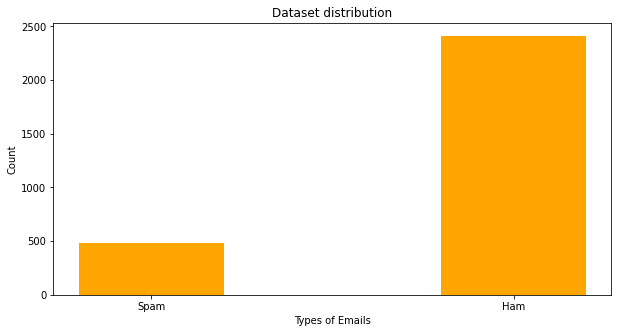

In [15]:
# creating the dataset

d_value = {'Spam':481, 'Ham':2412}
email_types = list(d_value.keys())
values = list(d_value.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot

plt.bar(email_types, values, color ='orange',
        width = 0.4)
 
plt.xlabel("Types of Emails")
plt.ylabel("Count")
plt.title("Dataset distribution")

For each word, we need to count the number of spam emails containing the word and the number of ham emails containing the same word. </br>
In order to do that, we use these numbers to calculate the probability later. We already separate spam and ham email above. We got two dicts and we can go through them and count

In [16]:
def countWordsInSpamAndHam(wordSet, dict):
  word_count = {}
  for word in wordSet:
    count = 0
    for key in dict:
      if word in dict[key]:
        count+=1
    word_count[word] = count
  return word_count 

In [17]:
spam_word_count = countWordsInSpamAndHam(feature_list, spam_email_dict)
ham_word_count = countWordsInSpamAndHam(feature_list, ham_email_dict)

In [18]:
print('The total word count for ham is: ', len(ham_word_count))

The total word count for ham is:  53207


Here, we can calculate $H(X)$. We use Laplacian smoothing because we need to calculate the probability.

#### Calculating $H(x)$ <a name='1.1'></a>

In [19]:
p_spam = (count_spam+1)/(count_spam+count_ham+2)
H_p_spam = -p_spam*np.log(p_spam)-(1-p_spam)*np.log((1-p_spam))
print("The H(X) is {}".format(H_p_spam))

The H(X) is 0.45028313289981026


For a specific word, we can calculate the information gain too. The formula is given by $-$ 
$$
IG(C,X_i)=H(C)-H(C|X_i)
$$

We have calculated $H(C)$ which is H(X). And the larger $IG(C,X_i)$, the better the classified variable

Here, we need to calculate $H(C|X_i)$

We have the formula $-$
$$
\begin{gathered}
H(C|X_i)=-\sum_x P(X_i=x)H(C|X=x)\\
=\sum_{x,c}P(X_i=x,C=c)log(P(C=x|X_i=x)\\
=\sum_{c\in \{\text{spam, legit}\}} \sum_{x\in \{0,1\}}P(X_i=x,C=c)log(P(C=x|X_i=x))
\end{gathered}
$$

where $P(X_i=x,C=c) =P(X_i=x|C=c)\times P(C=c)$ </br>
$\Rightarrow P(C=x|X_i=x)=\frac{P(X_i=x|C=c)\times P(C=c)}{P(X_i=x)}$

Here, $P(X_i=x)$ means, for example, when $P(X_i=0)$, it means how manny emails that do not contain the word divide by total number of emails.

We use the `calIGForEachWord()` function for this

In [20]:
def calIGForEachWord(wordSet, count_ham, count_spam, spam_word_count, ham_word_count, H_p_spam):
  IG_dict = {} 
  for word in wordSet:
    total = count_ham + count_spam
    spam_word = spam_word_count[word]
    ham_word = ham_word_count[word]

    IG_word = (-1) * (((count_spam-spam_word+1)/(count_spam+2)) * ((count_spam+1)/(total+2)) * 
                      np.log(((count_spam-spam_word+1)/(count_spam+2)) * ((count_spam+1)/(total+2))/((total-spam_word-ham_word+1)/(total+2))) # P(c=spam, x=0) log(P(c=spam|x=0))
                  + ((spam_word+1)/(count_spam+2)) * ((count_spam+1)/(total+2)) * 
                      np.log(((spam_word+1)/(count_spam+2)) * ((count_spam+1)/(total+2))/((spam_word+ham_word+1)/(total+2))) # P(c=spam, x=1) log(P(c=spam|x=1))
                  + ((count_ham-ham_word+1)/(count_ham+2)) * ((count_ham+1)/(total+2)) *
                      np.log(((count_ham-ham_word+1)/(count_ham+2)) * ((count_ham+1)/(total+2))/((total-spam_word-ham_word+1)/(total+2))) # P(c=ham, x=0) log(P(c=ham|x=0))
                  + ((ham_word+1)/(count_ham+2)) * ((count_ham+1)/(total+2)) * 
                      np.log(((ham_word+1)/(count_ham+2)) * ((count_ham+1)/(total+2))/((spam_word+ham_word+1)/(total+2)))) # P(c=ham, x=1) log(P(c=ham|x=1))
      
    IG_dict[word] = H_p_spam - IG_word
  return IG_dict     

In [21]:
IG_dict = calIGForEachWord(feature_list, count_ham, count_spam, spam_word_count, ham_word_count, H_p_spam)

After we calculate the IG for each word, we need to sort them in descending order. We need to select the larger value

In [22]:
IG_dict_sorted = dict(sorted(IG_dict.items(), key=operator.itemgetter(1),reverse=True))

Here, we will select top {10, 100, 1000} words based on the IG calculation result.

In [23]:
top_10_words = {}
top_100_words = {}
top_1000_words = {}

i=0
j=0
k=0
for key in IG_dict_sorted.keys():
  if i<10:
    i+=1
    top_10_words[key] = IG_dict_sorted[key]
  
  if j<100:
    j+=1
    top_100_words[key] = IG_dict_sorted[key]
  
  if k<1000:
    k+=1
    top_1000_words[key] = IG_dict_sorted[key]

In [24]:
all_of_words = {}
for key in IG_dict_sorted.keys():
  all_of_words[key] = IG_dict_sorted[key]

#### Top 10 words and their IG values <a name='1.2'></a>

In [25]:
for key in top_10_words.keys():
  print(key, top_10_words[key])

language 0.14326012650087844
remove 0.11330213365324149
free 0.10568069639925093
university 0.10561860619065228
linguistic 0.10286155209981812
money 0.07516328678905015
click 0.06857733773076702
our 0.05895458386952379
today 0.05450011637777258
sell 0.05364248242586378


Text(0.5, 1.0, 'Top 10 IG words')

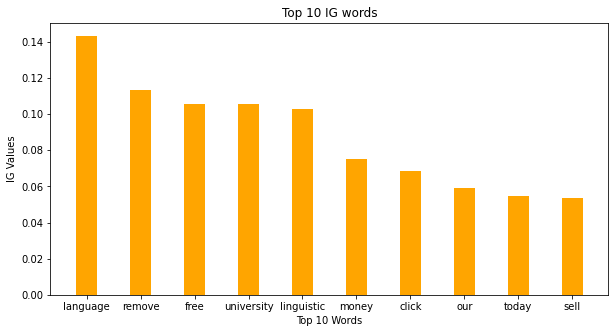

In [26]:
top_10_IG_words = list(top_10_words.keys())
top_10_IG_words_values = list(top_10_words.values())

top_100_IG_words = list(top_100_words.keys())
top_1000_IG_words = list(top_1000_words.keys())
  
fig = plt.figure(figsize = (10, 5))

plt.bar(top_10_IG_words, top_10_IG_words_values, color ='orange',
        width = 0.4)
 
plt.xlabel("Top 10 Words")
plt.ylabel("IG Values")
plt.title("Top 10 IG words")

## Part 02: Implementing the classifiers

### Build data
Before we build the classifers, we need to get the train data and test data. We need to create both binary features and feature frequency features. We need to create top {10, 100, 1000} features.

In [27]:
train_lemm_stop = lemm_stop[0:9]
test_lemm_stop = ['lingspam_public/lemm_stop/part10/']
print(test_lemm_stop)

['lingspam_public/lemm_stop/part10/']


In [28]:
def generateData(top_N_words, email_dict):
  feature_list = []
  if top_N_words==10:
    feature_list = list(top_10_words.keys())
  elif top_N_words==100:
    feature_list = list(top_100_words.keys())
  elif top_N_words==1000:
    feature_list = list(top_1000_words.keys())
  else:
    feature_list = list(all_of_words.keys())

  data_binary = []
  data_TF = []
  for key in email_dict.keys():
    temp_dict_binary = dict.fromkeys(feature_list, 0)
    temp_dict_TF = dict.fromkeys(feature_list, 0)
    for word in email_dict[key]:
      if word in feature_list:
        temp_dict_binary[word] = 1
        temp_dict_TF[word] = email_dict[key].count(word)


    if 'spm' in key:
      temp_dict_binary['spam_or_ham_label'] = 1
      temp_dict_TF['spam_or_ham_label'] = 1
    else:
      temp_dict_binary['spam_or_ham_label'] = 0
      temp_dict_TF['spam_or_ham_label'] = 0

    data_binary.append(temp_dict_binary)
    data_TF.append(temp_dict_TF)
  return data_binary, data_TF

In [29]:
train_spam_email_dict, train_ham_email_dict = separateSpamAndHam(train_lemm_stop, all_data)
test_spam_email_dict, test_ham_email_dict = separateSpamAndHam(test_lemm_stop, all_data)

Create top {10, 100, 1000} binary features and TF features

In [30]:
# top 10
train_data_10_binary_feature_spam, train_data_10_TF_feature_spam = generateData(10, train_spam_email_dict)
train_data_10_binary_feature_ham, train_data_10_TF_feature_ham = generateData(10, train_ham_email_dict)
train_data_10_binary_feature = train_data_10_binary_feature_spam + train_data_10_binary_feature_ham
train_data_10_TF_feature = train_data_10_TF_feature_spam + train_data_10_TF_feature_ham

test_data_10_binary_feature_spam, test_data_10_TF_feature_spam = generateData(10, test_spam_email_dict)
test_data_10_binary_feature_ham, test_data_10_TF_feature_ham = generateData(10, test_ham_email_dict)
test_data_10_binary_feature = test_data_10_binary_feature_spam + test_data_10_binary_feature_ham
test_data_10_TF_feature = test_data_10_TF_feature_spam + test_data_10_TF_feature_ham

# top 100
train_data_100_binary_feature_spam, train_data_100_TF_feature_spam = generateData(100, train_spam_email_dict)
train_data_100_binary_feature_ham, train_data_100_TF_feature_ham = generateData(100, train_ham_email_dict)
train_data_100_binary_feature = train_data_100_binary_feature_spam + train_data_100_binary_feature_ham
train_data_100_TF_feature = train_data_100_TF_feature_spam + train_data_100_TF_feature_ham

test_data_100_binary_feature_spam, test_data_100_TF_feature_spam = generateData(100, test_spam_email_dict)
test_data_100_binary_feature_ham, test_data_100_TF_feature_ham = generateData(100, test_ham_email_dict)
test_data_100_binary_feature = test_data_100_binary_feature_spam + test_data_100_binary_feature_ham
test_data_100_TF_feature = test_data_100_TF_feature_spam + test_data_100_TF_feature_ham

# top 1000
train_data_1000_binary_feature_spam, train_data_1000_TF_feature_spam = generateData(1000, train_spam_email_dict)
train_data_1000_binary_feature_ham, train_data_1000_TF_feature_ham = generateData(1000, train_ham_email_dict)
train_data_1000_binary_feature = train_data_1000_binary_feature_spam + train_data_1000_binary_feature_ham
train_data_1000_TF_feature = train_data_1000_TF_feature_spam + train_data_1000_TF_feature_ham

test_data_1000_binary_feature_spam, test_data_1000_TF_feature_spam = generateData(1000, test_spam_email_dict)
test_data_1000_binary_feature_ham, test_data_1000_TF_feature_ham = generateData(1000, test_ham_email_dict)
test_data_1000_binary_feature = test_data_1000_binary_feature_spam + test_data_1000_binary_feature_ham
test_data_1000_TF_feature = test_data_1000_TF_feature_spam + test_data_1000_TF_feature_ham

In [31]:
print('There are {} training features'.format(len(train_data_10_binary_feature)))
print('There are {} test features'.format(len(test_data_10_binary_feature)))

There are 2602 training features
There are 291 test features


In [32]:
print('Total number of top 10 features: ', len(train_data_10_TF_feature))

Total number of top 10 features:  2602


#### Displaying the TF features

In [33]:
df_train_TF = pd.DataFrame.from_dict(train_data_10_TF_feature)
df_train_TF.head()

,language,remove,free,university,linguistic,money,click,our,today,sell,spam_or_ham_label
0,0,0,0,0,0,0,0,0,0,0,1
1,0,3,0,0,0,0,0,0,0,0,1
2,0,4,1,0,0,3,0,6,2,0,1
3,0,0,2,0,0,2,0,0,0,0,1
4,0,2,0,0,0,1,1,1,0,0,1


#### Displaying the binary features

In [34]:
df_train_binary = pd.DataFrame.from_dict(train_data_10_binary_feature)
df_train_binary.head()

,language,remove,free,university,linguistic,money,click,our,today,sell,spam_or_ham_label
0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,1
2,0,1,1,0,0,1,0,1,1,0,1
3,0,0,1,0,0,1,0,0,0,0,1
4,0,1,0,0,0,1,1,1,0,0,1


### 2.1 $-$ Bernoulli NB Classifier with binary features

For Bernoulli NB with binary features, we have $m$ attributes $F=\{t_1,\cdots, t_m\}$ in the dataset. We need to calculate the probability of occurace of each word, which is $p(t_i|c)$. For each message, we can get $-$

$$
p(\overrightarrow{x}|c)=\prod_{i=1}^m p(t_i|c)^{x_i} (1-p(t_i|c))^{(1-x_i)}
$$

where $x_i\in \{0,1\}$ indicates the occurence.

We can estimate whether the email is spam or not spam by using the formula $-$
$$
\frac{p(c_s)\prod_{i=1}^m p(t_i|c_s)^{x_i}(1-p(t_i|c_s))^{(1-x_i)}}{\sum_{c\in \{c_s,c_h\}}p(c)\prod_{i=1}^m p(t_i|c)^{x_i}(1-p(t_i|c))^{(1-x_i)}}>T
$$

where $T$ is the threshold. But we do not know the threshold here so we can probably calculate a ratio here

$$
\begin{gathered}
\Rightarrow \frac{\frac{p(c_s)\prod_{i=1}^m p(t_i|c_s)^{x_i}(1-p(t_i|c_s))^{(1-x_i)}}{\sum_{c\in \{c_s,c_h\}}p(c)\prod_{i=1}^m p(t_i|c)^{x_i}(1-p(t_i|c))^{(1-x_i)}}}{\frac{p(c_h)\prod_{i=1}^m p(t_i|c_h)^{x_i}(1-p(t_i|c_h))^{(1-x_i)}}{\sum_{c\in \{c_s,c_h\}}p(c)\prod_{i=1}^m p(t_i|c)^{x_i}(1-p(t_i|c))^{(1-x_i)}}}=\frac{p(c_s)\prod_{i=1}^m p(t_i|c_s)^{x_i}(1-p(t_i|c_s))^{(1-x_i)}}{p(c_h)\prod_{i=1}^m p(t_i|c_h)^{x_i}(1-p(t_i|c_h))^{(1-x_i)}}
\end{gathered}
$$
</br>
</br>
If the ratio is greater than 1, then it is a spam else otherwise. $p(t|c)$ can be calculated by $-$ 

$$
p(t|c)=\frac{1+M_{t,c}}{2+M_c}
$$

Laplacian smoothing needs to be applied.

**NOTE:** $M_{t,c}$ is the number of tokens in class $c$ that contain token $t$. $M_c$ is the number of emails in class $c$

In [35]:
def BernoulliNBWithBinaryFeatures(top_N_features, email, numOfSpam, numOfHam, spam_word_count, ham_word_count):
  p_spam = (numOfSpam+1)/(numOfSpam+numOfHam+2)
  p_ham = (numOfHam+1)/(numOfSpam+numOfHam+2)

  p_spam_numerator = 1
  p_ham_denumerator = 1
  for i, x_i in enumerate(email):
    p_word_given_spam = (1+spam_word_count[top_N_features[i]])/(2+numOfSpam)
    p_word_given_ham = (1+ham_word_count[top_N_features[i]])/(2+numOfHam)

    p_spam_numerator = p_spam_numerator * np.power(p_word_given_spam, x_i) * np.power((1-p_word_given_spam), (1-x_i))
    p_ham_denumerator = p_ham_denumerator * np.power(p_word_given_ham, x_i) * np.power((1-p_word_given_ham), (1-x_i))

  pred = p_spam_numerator/p_ham_denumerator

  if pred>1:
    return 1
  else:
    return 0

#### Creating a Confusion Matrix for 10 features

In [36]:
test_data_10_binary_feature_list = []
for item in test_data_10_binary_feature:
  test_data_10_binary_feature_list.append(list(item.values()))

In [37]:
test_data_10_binary_feature_pred_result = []
test_data_10_binary_feature_true_label = []
for email in test_data_10_binary_feature_list:
  test_data_10_binary_feature_pred_result.append(BernoulliNBWithBinaryFeatures(top_10_IG_words, email[0:9], count_spam, count_ham, spam_word_count, ham_word_count))
  test_data_10_binary_feature_true_label.append(email[-1])

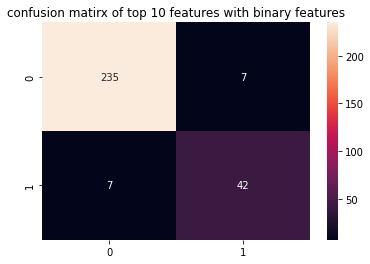

In [38]:
cf_matrix = confusion_matrix(test_data_10_binary_feature_true_label, test_data_10_binary_feature_pred_result)
plt.title("confusion matirx of top 10 features with binary features") 
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [39]:
acc_top_10_bernoulli = accuracy_score(test_data_10_binary_feature_true_label, test_data_10_binary_feature_pred_result)
recall_top_10_bernoulli = recall_score(test_data_10_binary_feature_true_label, test_data_10_binary_feature_pred_result, average='binary')
precision_top_10_bernoulli = precision_score(test_data_10_binary_feature_true_label, test_data_10_binary_feature_pred_result, average='binary')

print("The accuracy of bernoulli NB classifier is {}".format(acc_top_10_bernoulli))
print("The spam recall is {}".format(recall_top_10_bernoulli))
print("The spam precision is {}".format(precision_top_10_bernoulli))

The accuracy of bernoulli NB classifier is 0.9518900343642611
The spam recall is 0.8571428571428571
The spam precision is 0.8571428571428571


In [40]:
bernoulli_binary_10 = ["bernoulli NB", "10", acc_top_10_bernoulli, recall_top_10_bernoulli, precision_top_10_bernoulli]
summary_list = []
summary_list.append(bernoulli_binary_10)

#### Creating a Confusion Matrix for 100 features

In [41]:
test_data_100_binary_feature_list = []
for item in test_data_100_binary_feature:
  test_data_100_binary_feature_list.append(list(item.values()))

In [42]:
test_data_100_binary_feature_pred_result = []
test_data_100_binary_feature_true_label = []
for email in test_data_100_binary_feature_list:
  test_data_100_binary_feature_pred_result.append(BernoulliNBWithBinaryFeatures(top_100_IG_words, email[0:99], count_spam, count_ham, spam_word_count, ham_word_count))
  test_data_100_binary_feature_true_label.append(email[-1])

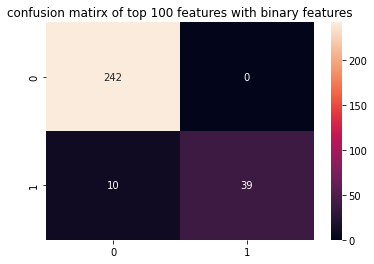

In [43]:
cf_matrix = confusion_matrix(test_data_100_binary_feature_true_label, test_data_100_binary_feature_pred_result)
plt.title("confusion matirx of top 100 features with binary features") 
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [44]:
acc_top_100_bernoulli = accuracy_score(test_data_100_binary_feature_true_label, test_data_100_binary_feature_pred_result)
recall_top_100_bernoulli = recall_score(test_data_100_binary_feature_true_label, test_data_100_binary_feature_pred_result, average='binary')
precision_top_100_bernoulli = precision_score(test_data_100_binary_feature_true_label, test_data_100_binary_feature_pred_result, average='binary')

print("The accuracy of bernoulli NB classifier is {}".format(acc_top_100_bernoulli))
print("The spam recall is {}".format(recall_top_100_bernoulli))
print("The spam precision is {}".format(precision_top_100_bernoulli))

The accuracy of bernoulli NB classifier is 0.9656357388316151
The spam recall is 0.7959183673469388
The spam precision is 1.0


In [45]:
bernoulli_binary_100 = ["bernoulli NB", "100", acc_top_100_bernoulli, recall_top_100_bernoulli, precision_top_100_bernoulli]
summary_list.append(bernoulli_binary_100)

#### Creating a Confusion Matrix for 1000 features

In [46]:
test_data_1000_binary_feature_list = []
for item in test_data_1000_binary_feature:
  test_data_1000_binary_feature_list.append(list(item.values()))

In [47]:
test_data_1000_binary_feature_pred_result = []
test_data_1000_binary_feature_true_label = []
for email in test_data_1000_binary_feature_list:
  test_data_1000_binary_feature_pred_result.append(BernoulliNBWithBinaryFeatures(top_1000_IG_words, email[0:999], count_spam, count_ham, spam_word_count, ham_word_count))
  test_data_1000_binary_feature_true_label.append(email[-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


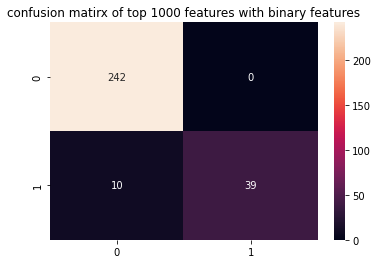

In [48]:
cf_matrix = confusion_matrix(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_pred_result)
plt.title("confusion matirx of top 1000 features with binary features") 
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [49]:
acc_top_1000_bernoulli = accuracy_score(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_pred_result)
recall_top_1000_bernoulli = recall_score(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_pred_result, average='binary')
precision_top_1000_bernoulli = precision_score(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_pred_result, average='binary')

print("The accuracy of bernoulli NB classifier is {}".format(acc_top_1000_bernoulli))
print("The spam recall is {}".format(recall_top_1000_bernoulli))
print("The spam precision is {}".format(precision_top_1000_bernoulli))

The accuracy of bernoulli NB classifier is 0.9656357388316151
The spam recall is 0.7959183673469388
The spam precision is 1.0


In [50]:
bernoulli_binary_1000 = ["bernoulli NB", "1000", acc_top_1000_bernoulli, recall_top_1000_bernoulli, precision_top_1000_bernoulli]
summary_list.append(bernoulli_binary_1000)

### 2.2 $-$ Multinomial NB with binary features

Multinomial Classifier basically ignores the negative evidence.

$$
\frac{p(c_s)\prod_{i=1}^m p(t_i|c_s)^{x_i}}{\sum_{c\in \{c_s,c_h\}}p(c)\prod_{i=1}^m p(t_i|c)^{x_i}}
$$

Here, we need to calculate $p(t|c)=\frac{1+M_{t,c}}{m+M_{c}}$

We can calculate a ratio to decide the class

In [51]:
def multinomialNBWithBinary(top_N_features, email, numOfSpam, numOfHam, spam_word_count, ham_word_count):
  p_spam = (numOfSpam+1)/(numOfSpam+numOfHam+2)
  p_ham = (numOfHam+1)/(numOfSpam+numOfHam+2)

  p_spam_numerator = 1
  p_ham_denumerator = 1

  for i, x_i in enumerate(email):
    p_word_given_spam = (1+spam_word_count[top_N_features[i]])/(len(top_N_features)+numOfSpam)
    p_word_given_ham = (1+ham_word_count[top_N_features[i]])/(len(top_N_features)+numOfHam)

    p_spam_numerator = p_spam_numerator * np.power(p_word_given_spam, x_i)
    p_ham_denumerator = p_ham_denumerator * np.power(p_word_given_ham, x_i)

  pred = p_spam_numerator/p_ham_denumerator
  if pred>1:
    return 1
  else:
    return 0


#### Creating a Confusion Matrix for 10 features

In [52]:
test_data_10_binary_feature_multinomial_pred_result = []
for email in test_data_10_binary_feature_list:
  test_data_10_binary_feature_multinomial_pred_result.append(multinomialNBWithBinary(top_10_IG_words, email[0:9], count_spam, count_ham, spam_word_count, ham_word_count))

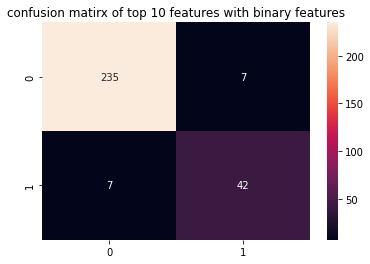

In [53]:
cf_matrix = confusion_matrix(test_data_10_binary_feature_true_label, test_data_10_binary_feature_multinomial_pred_result)
plt.title("confusion matirx of top 10 features with binary features") 
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [54]:
acc_top_10_multinomial_binary = accuracy_score(test_data_10_binary_feature_true_label, test_data_10_binary_feature_multinomial_pred_result)
recall_top_10_multinomial_binary = recall_score(test_data_10_binary_feature_true_label, test_data_10_binary_feature_multinomial_pred_result, average='binary')
precision_top_10_multinomial_binary = precision_score(test_data_10_binary_feature_true_label, test_data_10_binary_feature_multinomial_pred_result, average='binary')

print("The accuracy of multinomial binary NB classifier is {}".format(acc_top_10_multinomial_binary))
print("The spam recall is {}".format(recall_top_10_multinomial_binary ))
print("The spam precision is {}".format(precision_top_10_multinomial_binary))

The accuracy of multinomial binary NB classifier is 0.9518900343642611
The spam recall is 0.8571428571428571
The spam precision is 0.8571428571428571


In [55]:
multinomial_binary_10 = ["multinomial NB", "10", acc_top_10_multinomial_binary, recall_top_10_multinomial_binary, precision_top_10_multinomial_binary]
summary_list.append(multinomial_binary_10)

#### Creating a Confusion Matrix for 100 features

In [56]:
test_data_100_binary_feature_multinomial_pred_result = []
for email in test_data_100_binary_feature_list:
  test_data_100_binary_feature_multinomial_pred_result.append(multinomialNBWithBinary(top_100_IG_words, email[0:99], count_spam, count_ham, spam_word_count, ham_word_count))

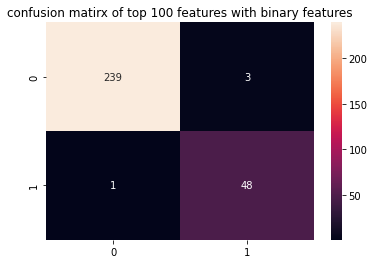

In [57]:
cf_matrix = confusion_matrix(test_data_100_binary_feature_true_label, test_data_100_binary_feature_multinomial_pred_result)
plt.title("confusion matirx of top 100 features with binary features") 
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [58]:
acc_top_100_multinomial_binary = accuracy_score(test_data_100_binary_feature_true_label, test_data_100_binary_feature_multinomial_pred_result)
recall_top_100_multinomial_binary = recall_score(test_data_100_binary_feature_true_label, test_data_100_binary_feature_multinomial_pred_result, average='binary')
precision_top_100_multinomial_binary = precision_score(test_data_100_binary_feature_true_label, test_data_100_binary_feature_multinomial_pred_result, average='binary')

print("The accuracy of multinomial binary NB classifier is {}".format(acc_top_100_multinomial_binary))
print("The spam recall is {}".format(recall_top_100_multinomial_binary ))
print("The spam precision is {}".format(precision_top_100_multinomial_binary))

The accuracy of multinomial binary NB classifier is 0.9862542955326461
The spam recall is 0.9795918367346939
The spam precision is 0.9411764705882353


In [59]:
multinomial_binary_100 = ["multinomial NB", "100", acc_top_100_multinomial_binary, recall_top_100_multinomial_binary, precision_top_100_multinomial_binary]
summary_list.append(multinomial_binary_100)

#### Creating a Confusion Matrix for 1000 features

In [60]:
test_data_1000_binary_feature_multinomial_pred_result = []
for email in test_data_1000_binary_feature_list:
  test_data_1000_binary_feature_multinomial_pred_result.append(multinomialNBWithBinary(top_1000_IG_words, email[0:999], count_spam, count_ham, spam_word_count, ham_word_count))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


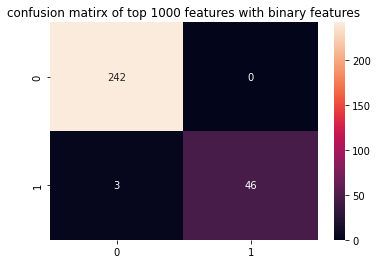

In [61]:
cf_matrix = confusion_matrix(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_multinomial_pred_result)
plt.title("confusion matirx of top 1000 features with binary features") 
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [62]:
acc_top_1000_multinomial_binary = accuracy_score(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_multinomial_pred_result)
recall_top_1000_multinomial_binary = recall_score(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_multinomial_pred_result, average='binary')
precision_top_1000_multinomial_binary = precision_score(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_multinomial_pred_result, average='binary')

print("The accuracy of multinomial binary NB classifier is {}".format(acc_top_1000_multinomial_binary))
print("The spam recall is {}".format(recall_top_1000_multinomial_binary ))
print("The spam precision is {}".format(precision_top_1000_multinomial_binary))

The accuracy of multinomial binary NB classifier is 0.9896907216494846
The spam recall is 0.9387755102040817
The spam precision is 1.0


In [63]:
multinomial_binary_1000 = ["multinomial NB", "1000", acc_top_1000_multinomial_binary, recall_top_1000_multinomial_binary, precision_top_1000_multinomial_binary]
summary_list.append(multinomial_binary_1000)

### 2.3 $-$ Multinomial NB with term frequency (TF) features

For this classifier, we need to know how many times it occurs in the email for each word $-$

$$
\Rightarrow \frac{p(c_s)\prod_{i=1}^m p(t_i|c_s)^{x_i}}{\sum_{c\in \{c_s,c_h\}}p(c)\prod_{i=1}^m p(t_i|c)^{x_i}}
$$

Here, $x_i$ is the number of times any character appears in the email

#### Creating a Confusion Matrix for 10 features

In [64]:
test_data_10_TF_feature_list = []
for item in test_data_10_TF_feature:
  test_data_10_TF_feature_list.append(list(item.values()))

In [65]:
test_data_10_TF_feature_pred_result = []
test_data_10_TF_feature_true_label = []
for email in test_data_10_TF_feature_list:
  test_data_10_TF_feature_pred_result.append(multinomialNBWithBinary(top_10_IG_words, email[0:9], count_spam, count_ham, spam_word_count, ham_word_count))
  test_data_10_TF_feature_true_label.append(email[-1])

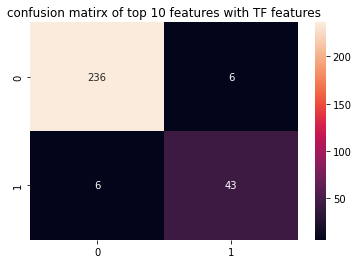

In [66]:
cf_matrix = confusion_matrix(test_data_10_TF_feature_true_label, test_data_10_TF_feature_pred_result)
plt.title("confusion matirx of top 10 features with TF features") 
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [67]:
acc_top_10_multinomial_TF = accuracy_score(test_data_10_TF_feature_true_label, test_data_10_TF_feature_pred_result)
recall_top_10_multinomial_TF = recall_score(test_data_10_TF_feature_true_label, test_data_10_TF_feature_pred_result, average='binary')
precision_top_10_multinomial_TF = precision_score(test_data_10_TF_feature_true_label, test_data_10_TF_feature_pred_result, average='binary')

print("The accuracy of multinomial TF NB classifier is {}".format(acc_top_10_multinomial_TF))
print("The spam recall is {}".format(recall_top_10_multinomial_TF ))
print("The spam precision is {}".format(precision_top_10_multinomial_TF))

The accuracy of multinomial TF NB classifier is 0.9587628865979382
The spam recall is 0.8775510204081632
The spam precision is 0.8775510204081632


In [68]:
multinomial_TF_10 = ["multinomial TF NB", "10", acc_top_10_multinomial_TF, recall_top_10_multinomial_TF, precision_top_10_multinomial_TF]
summary_list.append(multinomial_TF_10)

#### Creating a Confusion Matrix for 100 features

In [69]:
test_data_100_TF_feature_list = []
for item in test_data_100_TF_feature:
  test_data_100_TF_feature_list.append(list(item.values()))

In [70]:
test_data_100_TF_feature_pred_result = []
test_data_100_TF_feature_true_label = []
for email in test_data_100_TF_feature_list:
  test_data_100_TF_feature_pred_result.append(multinomialNBWithBinary(top_100_IG_words, email[0:99], count_spam, count_ham, spam_word_count, ham_word_count))
  test_data_100_TF_feature_true_label.append(email[-1])

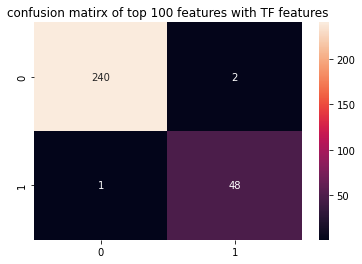

In [71]:
cf_matrix = confusion_matrix(test_data_100_TF_feature_true_label, test_data_100_TF_feature_pred_result)
plt.title("confusion matirx of top 100 features with TF features") 
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [72]:
acc_top_100_multinomial_TF = accuracy_score(test_data_100_TF_feature_true_label, test_data_100_TF_feature_pred_result)
recall_top_100_multinomial_TF = recall_score(test_data_100_TF_feature_true_label, test_data_100_TF_feature_pred_result, average='binary')
precision_top_100_multinomial_TF = precision_score(test_data_100_TF_feature_true_label, test_data_100_TF_feature_pred_result, average='binary')

print("The accuracy of multinomial TF NB classifier is {}".format(acc_top_100_multinomial_TF))
print("The spam recall is {}".format(recall_top_100_multinomial_TF ))
print("The spam precision is {}".format(precision_top_100_multinomial_TF))

The accuracy of multinomial TF NB classifier is 0.9896907216494846
The spam recall is 0.9795918367346939
The spam precision is 0.96


In [73]:
multinomial_TF_100 = ["multinomial TF NB", "100", acc_top_100_multinomial_TF, recall_top_100_multinomial_TF, precision_top_100_multinomial_TF]
summary_list.append(multinomial_TF_100)

#### Creating a Confusion Matrix for 1000 features

In [74]:
test_data_1000_TF_feature_list = []
for item in test_data_1000_TF_feature:
  test_data_1000_TF_feature_list.append(list(item.values()))

In [75]:
test_data_1000_TF_feature_pred_result = []
test_data_1000_TF_feature_true_label = []
for email in test_data_1000_TF_feature_list:
  test_data_1000_TF_feature_pred_result.append(multinomialNBWithBinary(top_1000_IG_words, email[0:999], count_spam, count_ham, spam_word_count, ham_word_count))
  test_data_1000_TF_feature_true_label.append(email[-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


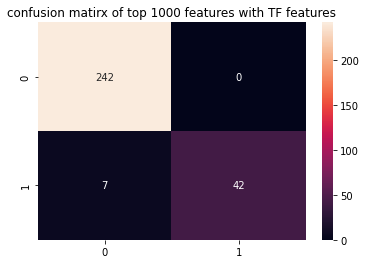

In [76]:
cf_matrix = confusion_matrix(test_data_1000_TF_feature_true_label, test_data_1000_TF_feature_pred_result)
plt.title("confusion matirx of top 1000 features with TF features") 
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [77]:
acc_top_1000_multinomial_TF = accuracy_score(test_data_1000_TF_feature_true_label, test_data_1000_TF_feature_pred_result)
recall_top_1000_multinomial_TF = recall_score(test_data_1000_TF_feature_true_label, test_data_1000_TF_feature_pred_result, average='binary')
precision_top_1000_multinomial_TF = precision_score(test_data_1000_TF_feature_true_label, test_data_1000_TF_feature_pred_result, average='binary')

print("The accuracy of multinomial TF NB classifier is {}".format(acc_top_1000_multinomial_TF))
print("The spam recall is {}".format(recall_top_1000_multinomial_TF ))
print("The spam precision is {}".format(precision_top_1000_multinomial_TF))

The accuracy of multinomial TF NB classifier is 0.9759450171821306
The spam recall is 0.8571428571428571
The spam precision is 1.0


In [78]:
multinomial_TF_1000 = ["multinomial TF NB", "1000", acc_top_1000_multinomial_TF, recall_top_1000_multinomial_TF, precision_top_1000_multinomial_TF]
summary_list.append(multinomial_TF_1000)

### Part 02 Submission <a name='Part-02'></a>

In [79]:
df = pd.DataFrame(summary_list,columns =['model', 'number of features', 'accuracy', 'recall', 'precision'])

In [80]:
df.head(10)

,model,number of features,accuracy,recall,precision
0,bernoulli NB,10,0.951890,0.857143,0.857143
1,bernoulli NB,100,0.965636,0.795918,1.000000
2,bernoulli NB,1000,0.965636,0.795918,1.000000
3,multinomial NB,10,0.951890,0.857143,0.857143
4,multinomial NB,100,0.986254,0.979592,0.941176
5,multinomial NB,1000,0.989691,0.938776,1.000000
6,multinomial TF NB,10,0.958763,0.877551,0.877551
7,multinomial TF NB,100,0.989691,0.979592,0.960000
8,multinomial TF NB,1000,0.975945,0.857143,1.000000


## Part 03: Creating a SVM classifier

Cross validation is used to train the model. We have binary features and TF features for both the datasets. </br>
Our objective is to find the top 1000 features and we will use gridsearch algorithm to select parameters

In [81]:
X_train = []
y_train = []
for item in train_data_1000_TF_feature:
  X_train.append(list(item.values())[0:-1])
  y_train.append(list(item.values())[-1])

X_test = []
y_test = []
for item in test_data_1000_TF_feature:
  X_test.append(list(item.values())[0:-1])
  y_test.append(list(item.values())[-1])

We can use Principal Component Analysis (PCA) for dimensionality reduction. </br>
Upon checking PoV (proportion of Variance) to select features, we can select the features and the SVM model is then fit and gridsearchcv is used to tune the model.

#### Fine-tuning the SVM Model

In [82]:
best_recall = []
best_precision = []
Gamma = [0.01, 0.001, 0.00001]
C = [1000, 10000, 100000]
for gamma in Gamma:
  for c in C:
    clf = svm.SVC(gamma=gamma, C=c, kernel='rbf')
    clf.fit(X_train, y_train)
    scores = cross_validate(
        clf, 
        X_train, 
        y_train, 
        cv=5,
        scoring=('precision', 'recall')
        )
    print("C = {}".format(c))
    print("gamma = {}".format(gamma))
    print("best recall = {}".format(max(scores['test_recall'])))
    print("best precision = {}".format(max(scores['test_precision'])))
    best_recall.append(max(scores['test_recall']))
    best_precision.append(max(scores['test_precision']))    

C = 1000
gamma = 0.01
best recall = 0.6744186046511628
best precision = 1.0
C = 10000
gamma = 0.01
best recall = 0.6744186046511628
best precision = 1.0
C = 100000
gamma = 0.01
best recall = 0.6744186046511628
best precision = 1.0
C = 1000
gamma = 0.001
best recall = 0.9534883720930233
best precision = 0.9642857142857143
C = 10000
gamma = 0.001
best recall = 0.9534883720930233
best precision = 0.9647058823529412
C = 100000
gamma = 0.001
best recall = 0.9534883720930233
best precision = 0.9647058823529412
C = 1000
gamma = 1e-05
best recall = 0.9540229885057471
best precision = 1.0
C = 10000
gamma = 1e-05
best recall = 0.9540229885057471
best precision = 0.9878048780487805
C = 100000
gamma = 1e-05
best recall = 0.9534883720930233
best precision = 0.9879518072289156


#### Part 03 Submission <a name='Part-03'></a>

In [83]:
clf = svm.SVC(gamma=0.001, C=100000, kernel='rbf')
clf.fit(X_train, y_train)
y_pred_TF = clf.predict(X_test)  
print(classification_report(y_test, y_pred_TF)) 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       242
           1       0.95      0.84      0.89        49

    accuracy                           0.97       291
   macro avg       0.96      0.91      0.94       291
weighted avg       0.97      0.97      0.96       291



Evaluating the SVM Model

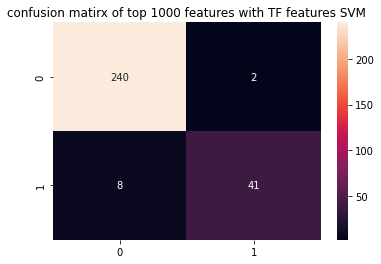

In [84]:
cf_matrix = confusion_matrix(y_test, y_pred_TF)
plt.title("confusion matirx of top 1000 features with TF features SVM") 
sns.heatmap(cf_matrix, annot=True, fmt='d')

## Part 04: Adversarial classification

In [85]:
def NB_classifier_returnProb(top_N_features, email, numOfSpam, numOfHam, spam_word_count, ham_word_count):
  p_spam = (numOfSpam+1)/(numOfSpam+numOfHam+2)
  p_ham = (numOfHam+1)/(numOfSpam+numOfHam+2)

  p_x_given_spam = 1
  p_x_given_ham = 1
  for i, x_i in enumerate(email):
    p_word_given_spam = (1+spam_word_count[top_N_features[i]])/(2+numOfSpam)
    p_word_given_ham = (1+ham_word_count[top_N_features[i]])/(2+numOfHam)

    p_x_given_spam = p_x_given_spam * np.power(p_word_given_spam, x_i) * np.power((1-p_word_given_spam), (1-x_i))
    p_x_given_ham = p_x_given_ham * np.power(p_word_given_ham, x_i) * np.power((1-p_word_given_ham), (1-x_i))

  p_x_denumerator = (p_spam * p_x_given_spam) + (p_ham * p_x_given_ham)
  p_spam_given_x = (p_spam * p_x_given_spam)/p_x_denumerator
  p_ham_given_x = (p_ham * p_x_given_ham)/p_x_denumerator
  
  return p_spam_given_x, p_ham_given_x

In [86]:
def modifyDataReturnNewProb(top_N_features, test_data_10_binary_feature_list, numOfSpam, numOfHam, spam_word_count, ham_word_count):
  new_delta = []
  modify_test_data = copy.deepcopy(test_data_10_binary_feature_list)
  for i, email in enumerate(test_data_10_binary_feature_list):    
    if email[-1]==1:
      temp_delta_list = []
      temp_email = email[0:-1]
      for index, x_i in enumerate(temp_email):
        if x_i==0:
          p_spam_given_x_before, p_ham_given_x_before = NB_classifier_returnProb(top_10_IG_words, modify_test_data[i][0:-1], count_spam, count_ham, spam_word_count, ham_word_count)
          LO_xi = np.log(p_spam_given_x_before/p_ham_given_x_before)
          modify_test_data[i][index] = 1
          p_spam_given_x_after, p_ham_given_x_after = NB_classifier_returnProb(top_10_IG_words, modify_test_data[i][0:-1], count_spam, count_ham, spam_word_count, ham_word_count)
          LO_xi_prime = np.log(p_spam_given_x_after/p_ham_given_x_after)
          delta_i = max(LO_xi - LO_xi_prime,0)
          temp_delta_list.append((delta_i, index))
          modify_test_data[i][index] = 0      
        else:
          p_spam_given_x, p_ham_given_x = NB_classifier_returnProb(top_10_IG_words, modify_test_data[i][0:-1], count_spam, count_ham, spam_word_count, ham_word_count)
          temp_delta_list.append((0, index))
      new_delta.append(temp_delta_list)
  return new_delta

In [87]:
new_delta = modifyDataReturnNewProb(top_10_IG_words, test_data_10_binary_feature_list, count_spam, count_ham, spam_word_count, ham_word_count)

`new_prob` records the probability of spam given $x$. </br>
We also sort them in order of their probabilities.

In [88]:
new_delta_sorted = []
for item in new_delta:
  new_delta_sorted.append(sorted(item, key=lambda val : val[0], reverse=True))

The cost for each spam email is also calculated

In [89]:
def calCostSpamEmail(top_N_features, test_data_10_binary_feature_list, numOfSpam, numOfHam, spam_word_count, ham_word_count, new_delta_sorted):
  isHam = False
  modify_test_data = copy.deepcopy(test_data_10_binary_feature_list)
  cost_list = []
  for i, email in enumerate(test_data_10_binary_feature_list):    
    if email[-1]==1:

      cost = 0
      for index, prob_list in enumerate(new_delta_sorted):  
        for item in prob_list:
          p_spam, word_index = item
          modify_test_data[i][word_index] = 1
          cost +=1
          
          p_spam_given_x, p_ham_given_x = NB_classifier_returnProb(top_N_features, modify_test_data[i][0:-1], numOfSpam, numOfHam, spam_word_count, ham_word_count)
          if cost>10:
            cost = 0
            modify_test_data[i] = test_data_10_binary_feature_list[i]
            break
          if p_spam_given_x/p_ham_given_x < 1:
            isHam = True
            break
          else:
            continue
        if isHam:
          break
        else:
          continue
      cost_list.append(cost)
  return cost_list, modify_test_data

In [90]:
cost, modify_test_data = calCostSpamEmail(top_10_IG_words, test_data_10_binary_feature_list, count_spam, count_ham, spam_word_count, ham_word_count, new_delta_sorted)

In [91]:
print(cost)

[1, 3, 1, 1, 3, 1, 10, 1, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 3, 3, 1, 1, 2, 3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 2]


In [92]:
cost_avg = np.sum(cost)/49

print("The average cost is: {}".format(cost_avg))

The average cost is: 1.7142857142857142


In [93]:
modify_test_data_10_binary_feature_pred_result = []
modify_test_data_10_binary_feature_true_label = []
for email in modify_test_data:
  modify_test_data_10_binary_feature_pred_result.append(BernoulliNBWithBinaryFeatures(top_10_IG_words, email[0:9], count_spam, count_ham, spam_word_count, ham_word_count))
  modify_test_data_10_binary_feature_true_label.append(email[-1])

#### Baseline Bernoulli NB classifier being applied <a name='4.1'></a>

In [94]:
modify_acc_top_10_bernoulli = accuracy_score(modify_test_data_10_binary_feature_true_label, modify_test_data_10_binary_feature_pred_result)
modify_recall_top_10_bernoulli = recall_score(modify_test_data_10_binary_feature_true_label, modify_test_data_10_binary_feature_pred_result, average='binary')
modify_precision_top_10_bernoulli = precision_score(modify_test_data_10_binary_feature_true_label, modify_test_data_10_binary_feature_pred_result, average='binary')

print("The accuracy of original bernoulli NB classifier applied on modified dataset is {}".format(modify_acc_top_10_bernoulli))
print("The spam recall is {}".format(modify_recall_top_10_bernoulli))
print("The precision is {}".format(modify_precision_top_10_bernoulli))
print("The false positive rate is {}".format(1-modify_recall_top_10_bernoulli))
print("The false negative rate is {}".format(1-modify_precision_top_10_bernoulli))

The accuracy of original bernoulli NB classifier applied on modified dataset is 0.8419243986254296
The spam recall is 0.20408163265306123
The precision is 0.5882352941176471
The false positive rate is 0.7959183673469388
The false negative rate is 0.4117647058823529


In [95]:
def modified_classifier(top_N_features, test_data_10_binary_feature_list, original_test_set, numOfSpam, numOfHam, spam_word_count, ham_word_count):
  p_spam = (numOfSpam+1)/(numOfSpam+numOfHam+2)
  p_ham = (numOfHam+1)/(numOfSpam+numOfHam+2)

  p_spam_numerator = 1
  p_ham_denumerator = 1
  p_spam_sum = 0
  temp_email = original_test_set[0:-1]

  for i, x_i in enumerate(test_data_10_binary_feature_list):
    #print(i)
    p_word_given_spam = (1+spam_word_count[top_N_features[i]])/(2+numOfSpam)
    p_word_given_ham = (1+ham_word_count[top_N_features[i]])/(2+numOfHam)
    if temp_email[i]!=x_i:
      p_spam_sum += p_word_given_spam
    p_ham_denumerator = p_ham_denumerator * np.power(p_word_given_ham, x_i) * np.power((1-p_word_given_ham), (1-x_i))

  pred = (p_spam_sum*p_spam)/(p_ham_denumerator*p_ham)
  
  if pred>1:
    return 1 # 1 is spam
  else:
    return 0 # 0 is ham

In [96]:
modify_test_data_10_binary_feature_pred_result = []
modify_test_data_10_binary_feature_true_label = []
for index, email in enumerate(modify_test_data):
  modify_test_data_10_binary_feature_pred_result.append(modified_classifier(top_10_IG_words, email[0:-1], test_data_10_binary_feature_list[index], count_spam, count_ham, spam_word_count, ham_word_count))
  modify_test_data_10_binary_feature_true_label.append(email[-1])

#### Updated Bernoulli NB classifier being applied <a name='4.2'></a>

In [97]:
modify_acc_top_10_bernoulli = accuracy_score(modify_test_data_10_binary_feature_true_label, modify_test_data_10_binary_feature_pred_result)
modify_recall_top_10_bernoulli = recall_score(modify_test_data_10_binary_feature_true_label, modify_test_data_10_binary_feature_pred_result, average='binary')
modify_precision_top_10_bernoulli = precision_score(modify_test_data_10_binary_feature_true_label, modify_test_data_10_binary_feature_pred_result, average='binary')

print("The accuracy of updated bernoulli NB classifier applied on modified datset is {}".format(modify_acc_top_10_bernoulli))
print("The spam recall is {}".format(modify_recall_top_10_bernoulli))
print("The spam precision is {}".format(modify_precision_top_10_bernoulli))

The accuracy of updated bernoulli NB classifier applied on modified datset is 0.9381443298969072
The spam recall is 0.6326530612244898
The spam precision is 1.0


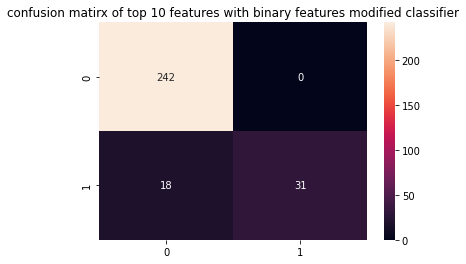

In [98]:
cf_matrix = confusion_matrix(modify_test_data_10_binary_feature_true_label, modify_test_data_10_binary_feature_pred_result)
plt.title("confusion matirx of top 10 features with binary features modified classifier") 
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [99]:
print("The false positive rate is {}".format(19/49))
print("The false negative rate is {}".format(0/242))


The false positive rate is 0.3877551020408163
The false negative rate is 0.0
